## Generate correlated features (mimicking GC content, BGS and gBGC) 

Text(0, 0.5, 'x3')

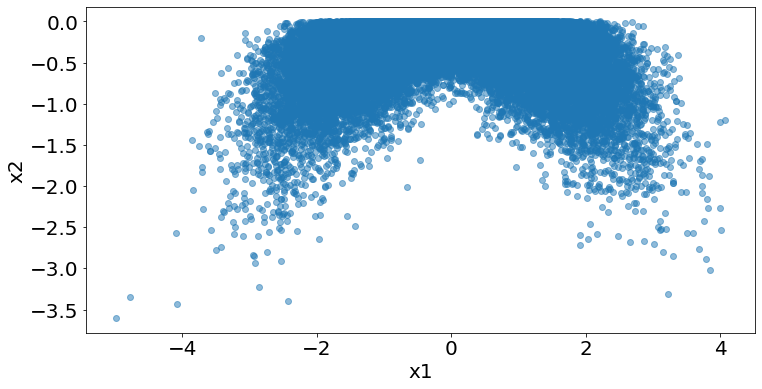

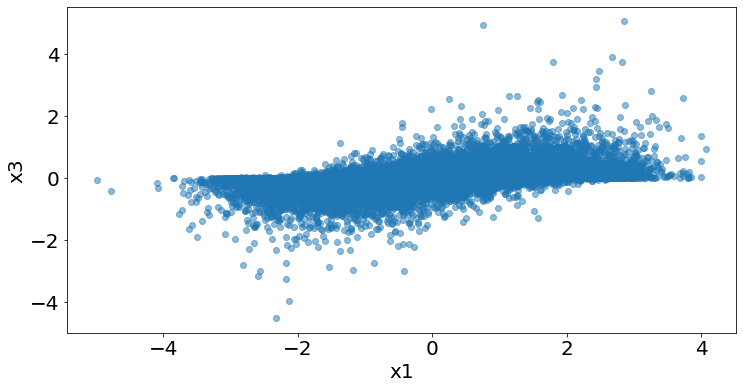

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

NUMBER_EXAMPLES = 100000 # Number of intervals

MEAN = [0, 0, 0]  # Means for the three features

# Covariance matrix (symmetric and positive-definite)
# we need non-zero covariances to exhibit the bias in residuals as a function of x1, but not as a function of x2
COV = [
    [1.0, 0.8, 0.5],  # Variance of X1 and covariances with X2 and X3
    [0.8, 1.0, 0.3],  # Covariance of X2 with X1 and variance of X2 and covariance with X3
    [0.5, 0.3, 1.0]   # Covariance of X3 with X1 and X2 and variance of X3
]
# COV = [
#     [1.0, 0.0, 0.0],  # Variance of X1 and covariances with X2 and X3
#     [0.0, 1.0, 0.0],  # Covariance of X2 with X1 and variance of X2 and covariance with X3
#     [0.0, 0.0, 1.0]   # Covariance of X3 with X1 and X2 and variance of X3
# ]

x1s, x2s, x3s = np.random.multivariate_normal(MEAN, COV, size=NUMBER_EXAMPLES).T

x2s = -0.2 * x2s**2 
x3s = +0.05 * x3s**3

plt.figure(figsize=(12, 6))
plt.plot(x1s, x2s, 'o', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')

plt.figure(figsize=(12, 6))
plt.plot(x1s, x3s, 'o', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x3')

## True mapping from features to target (mimicking SNV counts)

Text(0, 0.5, 'number of examples')

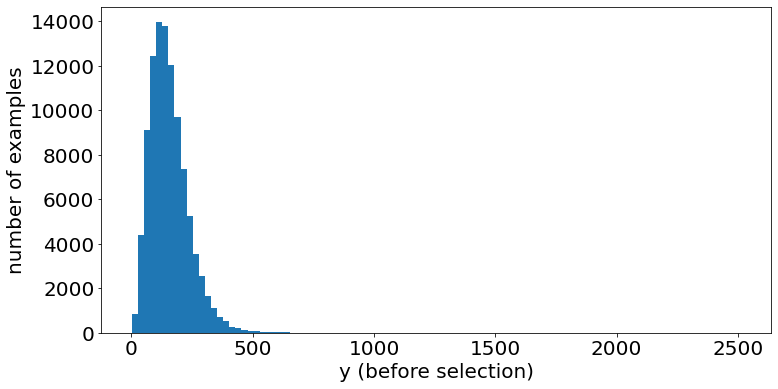

In [2]:
# parameters of true model 
A = 5 
B1 = 0.5 # 0.05 
B2 = 0.4
B3 = 0.3

TRUE_RATE = lambda x1, x2, x3: np.exp(A + B1*x1 + B2*x2 + B3*x3) # rate function
# TRUE_RATE = lambda x1, x2, x3: np.exp(A + B1*x1**2 + B2*x2 + B3*x3) # rate function

ys = np.random.poisson(lam=TRUE_RATE(x1s, x2s, x3s)) # target 

plt.figure(figsize=(12, 6))
plt.hist(ys, bins=100)
plt.xlabel('y (before selection)')
plt.ylabel('number of examples')

## Introduce selection into a small fraction of examples

In [3]:
# Take x% of the examples, declare them to be positive examples, and reduce their y values (possibly in proportion to x1), 
# to mimic the effect of negative selection (and how it occurs more often in regions with higher GC content)

# Take the remaining examples, declare them to be neutral (negative) examples, and do not change their y values

POSITIVE_FRACTION = 0.2
FRACTIONAL_REDUCTION_IN_Y = 0.1

num_pos = int(POSITIVE_FRACTION*NUMBER_EXAMPLES)
# x1_factor = (x1s - x1s.min()) / (x1s.max() - x1s.min())
# y_pos = ys[:num_pos] * (1 - max_fractional_reduction_in_y * x1_factor[:num_pos])
y_pos = ys[:num_pos] * (1 - FRACTIONAL_REDUCTION_IN_Y)
y_neg = ys[num_pos:]
ys = np.concatenate([y_pos, y_neg])

constrained = num_pos*[True] + (NUMBER_EXAMPLES-num_pos)*[False]

DATA = pd.DataFrame({'x1': x1s, 'x2': x2s, 'x3': x3s, 'y': ys, 'constrained': constrained})
DATA

,x1,x2,x3,y,constrained
0,1.040675,-0.023913,0.002934,237.6,True
1,0.459784,-0.037816,-0.000021,161.1,True
2,0.728918,-0.657935,0.000499,142.2,True
3,0.404288,-0.064369,-0.018839,158.4,True
4,0.130313,-0.104290,0.000141,117.9,True
...,...,...,...,...,...
99995,-1.635912,-0.543641,-0.239428,41.0,False
99996,0.232522,-0.003557,0.216937,187.0,False
99997,-0.589721,-0.020584,0.233016,104.0,False
99998,-1.749342,-0.283173,-0.276534,44.0,False


<AxesSubplot:xlabel='x3', ylabel='y'>

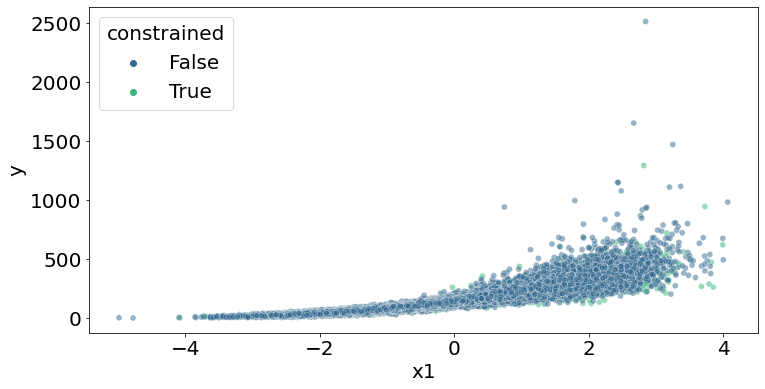

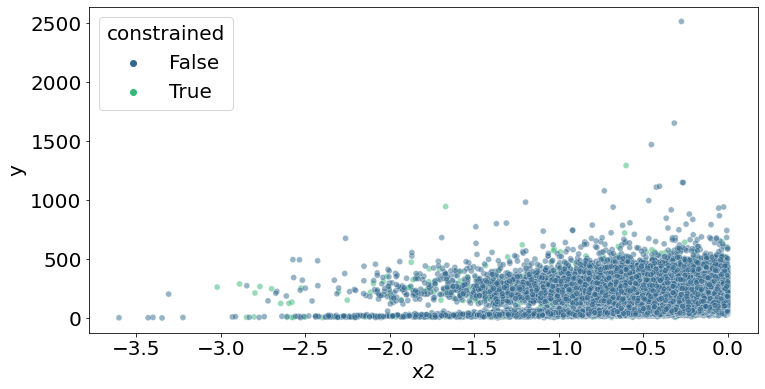

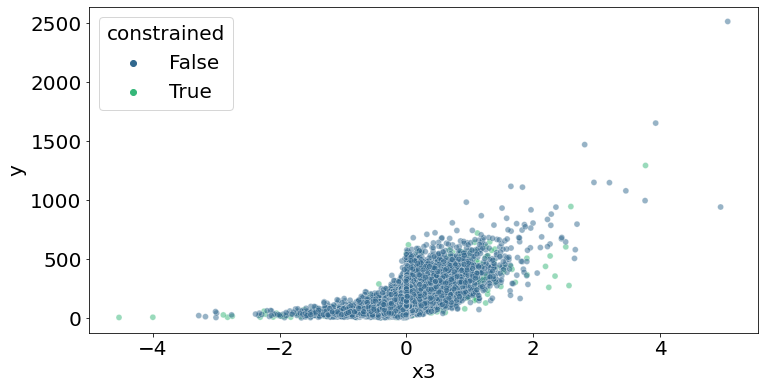

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x1', y='y', hue='constrained', palette='viridis', alpha=0.5)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x2', y='y', hue='constrained', palette='viridis', alpha=0.5)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x3', y='y', hue='constrained', palette='viridis', alpha=0.5)


## Approximate models of neutral data

In [5]:
import statsmodels.api as sm

def fit_poisson_model(features):
    data_neg = DATA[DATA['constrained'] == 0]
    x_model_neg = sm.add_constant(data_neg[features])
    model = sm.Poisson(data_neg['y'], x_model_neg).fit()
    num_feat = len(features)
    x_model = sm.add_constant(DATA[features])
    DATA[f'predicted_y_model{num_feat}'] = model.predict(x_model)
    DATA[f'standardized_residuals_model{num_feat}'] = (
        DATA[f'predicted_y_model{num_feat}'] - DATA['y'] 
    ) / np.sqrt(DATA[f'predicted_y_model{num_feat}'])
    return model.params

# Fit Poisson Model 1: y ~ x1
coefficients_model1 = fit_poisson_model(['x1'])
print("Coefficients for Model 1:", coefficients_model1)

# Fit Poisson Model 2: y ~ x1 + x2
coefficients_model2 = fit_poisson_model(['x1', 'x2'])
print("Coefficients for Model 2:", coefficients_model2)

# Fit Poisson Model 3: y ~ x1 + x2 + x3
coefficients_model3 = fit_poisson_model(['x1', 'x2', 'x3'])
print("Coefficients for Model 3:", coefficients_model3)

DATA

Optimization terminated successfully.
         Current function value: 5.135297
         Iterations 5
Coefficients for Model 1: const    4.937851
x1       0.479532
dtype: float64
Optimization terminated successfully.
         Current function value: 4.204466
         Iterations 6
Coefficients for Model 2: const    5.001576
x1       0.526556
x2       0.405025
dtype: float64
Optimization terminated successfully.
         Current function value: 3.880290
         Iterations 6
Coefficients for Model 3: const    5.000257
x1       0.499772
x2       0.399680
x3       0.300290
dtype: float64


,x1,x2,x3,y,constrained,predicted_y_model1,standardized_residuals_model1,predicted_y_model2,standardized_residuals_model2,predicted_y_model3,standardized_residuals_model3
0,1.040675,-0.023913,0.002934,237.6,True,229.726076,-0.519501,254.643417,1.068047,247.567054,0.633462
1,0.459784,-0.037816,-0.000021,161.1,True,173.874168,0.968758,186.487023,1.859035,183.997845,1.688061
2,0.728918,-0.657935,0.000499,142.2,True,197.826428,3.954932,167.153300,1.930059,164.306967,1.724651
3,0.404288,-0.064369,-0.018839,158.4,True,169.308011,0.838314,179.178918,1.552314,176.077609,1.332206
4,0.130313,-0.104290,0.000141,117.9,True,148.463645,2.508390,152.620329,2.810461,151.979255,2.764381
...,...,...,...,...,...,...,...,...,...,...,...
99995,-1.635912,-0.543641,-0.239428,41.0,False,63.648701,2.838890,50.399862,1.324057,49.082044,1.153612
99996,0.232522,-0.003557,0.216937,187.0,False,155.921480,-2.488899,167.766200,-1.484954,177.716187,-0.696407
99997,-0.589721,-0.020584,0.233016,104.0,False,105.115584,0.108810,108.063343,0.390881,117.598453,1.253974
99998,-1.749342,-0.283173,-0.276534,44.0,False,60.279109,2.096753,52.760222,1.206040,50.895035,0.966493


In [6]:
def plot_ys(constrained, feature):
    df = DATA[DATA['constrained'] == constrained]

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model1'], 'o', label='Predicted y')
    plt.xlabel(feature)
    plt.title('Model 1')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model2'], 'o', label='Predicted y')
    plt.xlabel(feature)
    plt.title('Model 2')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model3'], 'o', label='Predicted y')
    plt.xlabel(feature)
    plt.title('Model 3')
    plt.legend()

def plot_ys_all(constrained):
    plot_ys(constrained, 'x1')
    plot_ys(constrained, 'x2')
    plot_ys(constrained, 'x3')

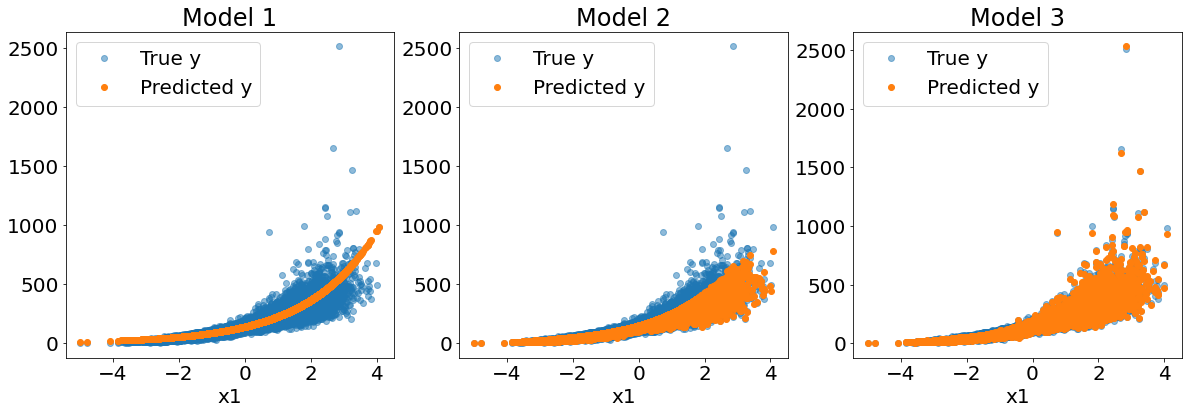

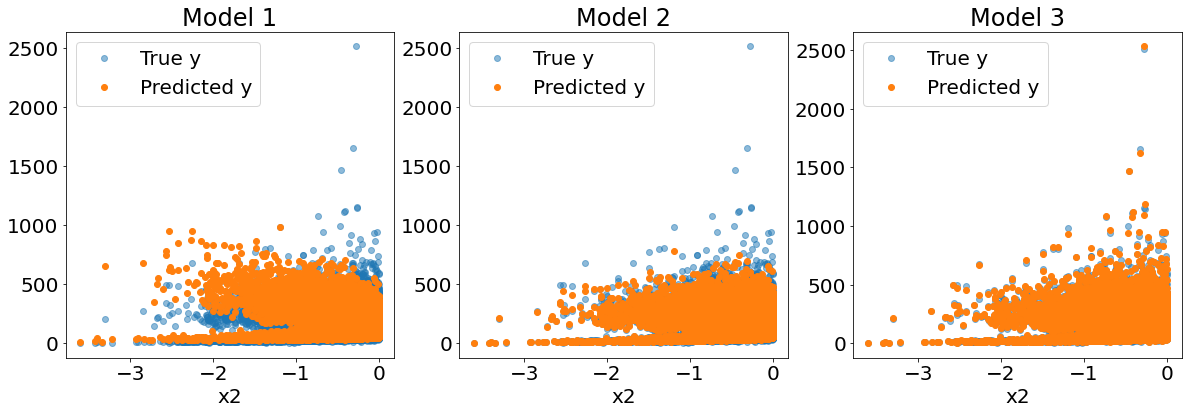

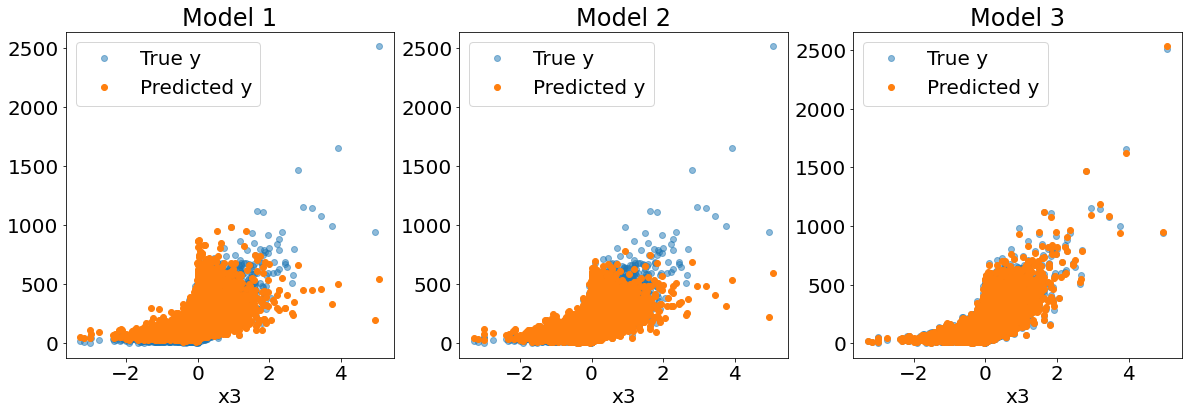

In [7]:
plot_ys_all(constrained=False)

## Variations in model complexity can result in radically different residual patterns

.. even when features are independent of one another (which can be confirmed by re-running the notebook but with COV equal to the identity matrix)

In [19]:
def plot_residuals(constrained, num_feat, stratification_feature):
    df = DATA[DATA['constrained'] == constrained].copy()

    df[f'{stratification_feature}_bin_midpoints'] = (pd
        .cut(df[stratification_feature], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )
    average_residual = df.groupby(f'{stratification_feature}_bin_midpoints')[f'standardized_residuals_model{num_feat}'].mean()  

    plt.subplot(1, 3, num_feat)
    plt.scatter(df[stratification_feature], df[f'standardized_residuals_model{num_feat}'], alpha=0.7, label='standardized residuals')
    plt.plot(average_residual.index, average_residual.values, color='red', lw=2, label=f'average') 
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'Model {num_feat}')
    plt.xlabel(stratification_feature)
    plt.ylim(-10, 10)
    plt.legend()

def plot_residuals_wrapper(constrained, stratification_feature):
    plt.figure(figsize=(20, 6))
    plot_residuals(constrained, num_feat=1, stratification_feature=stratification_feature)
    plot_residuals(constrained, num_feat=2, stratification_feature=stratification_feature)
    plot_residuals(constrained, num_feat=3, stratification_feature=stratification_feature)

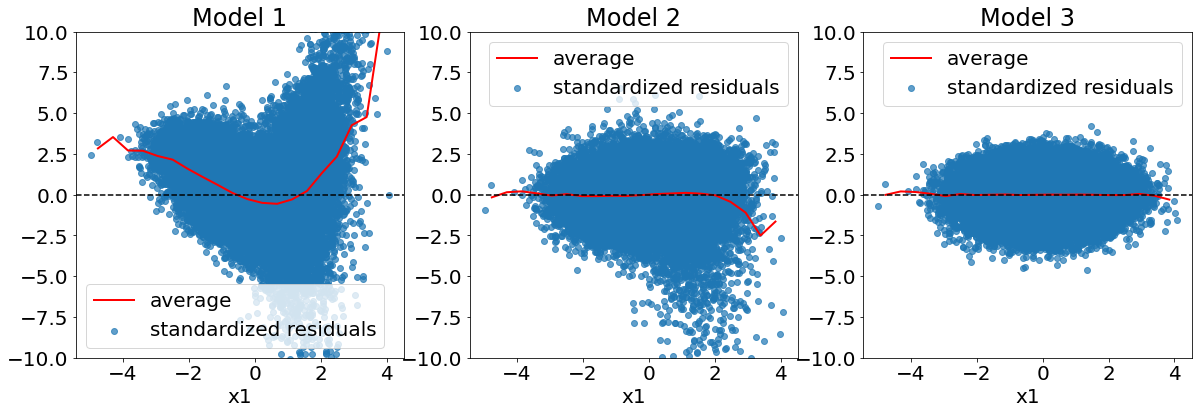

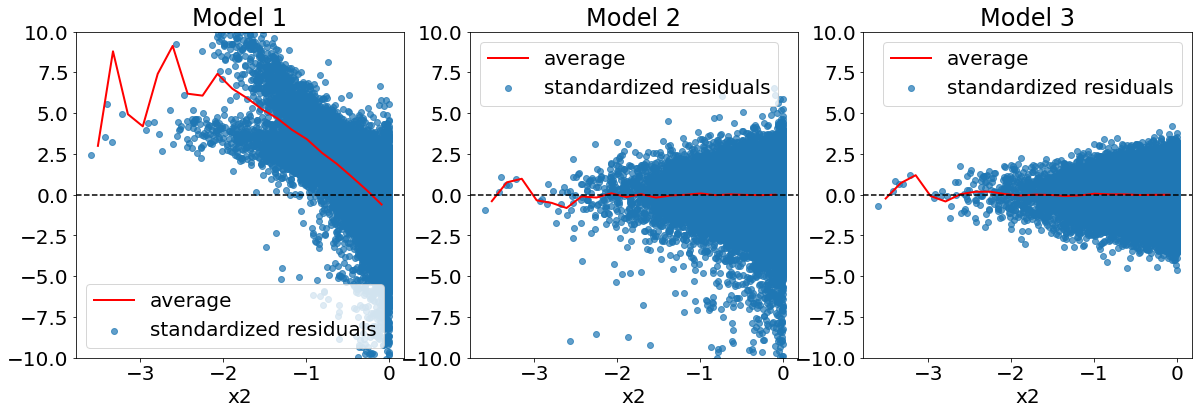

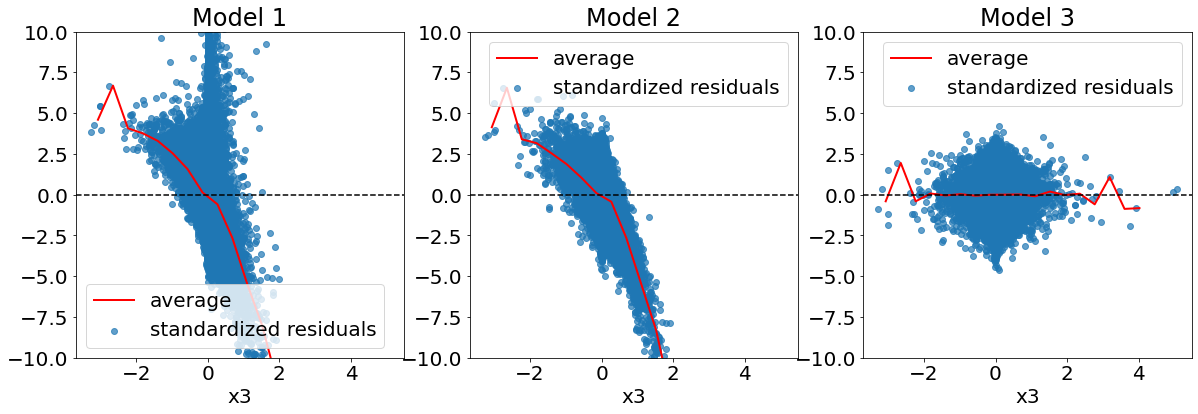

In [20]:
plot_residuals_wrapper(constrained=False, stratification_feature='x1')
plot_residuals_wrapper(constrained=False, stratification_feature='x2')
plot_residuals_wrapper(constrained=False, stratification_feature='x3')

In [10]:
# Notice that the patterns change radically as a function of model. 

# We know that SNV density declines with GC content. 
# Yet that doesn’t necessarily mean that SNV density, 
# predicted under a model that does not include GC content, 
# would be constant as a function of GC content. 
# In other words, that such a model would overestimate SNV density at high GC content. 
# That’s because the model may include a feature that co-varies with GC content. 
# When we realize this, it becomes clear that residuals could increase or decrease with GC content, 
# depending upon what features were included in the model, and how those features co-vary with GC content. 


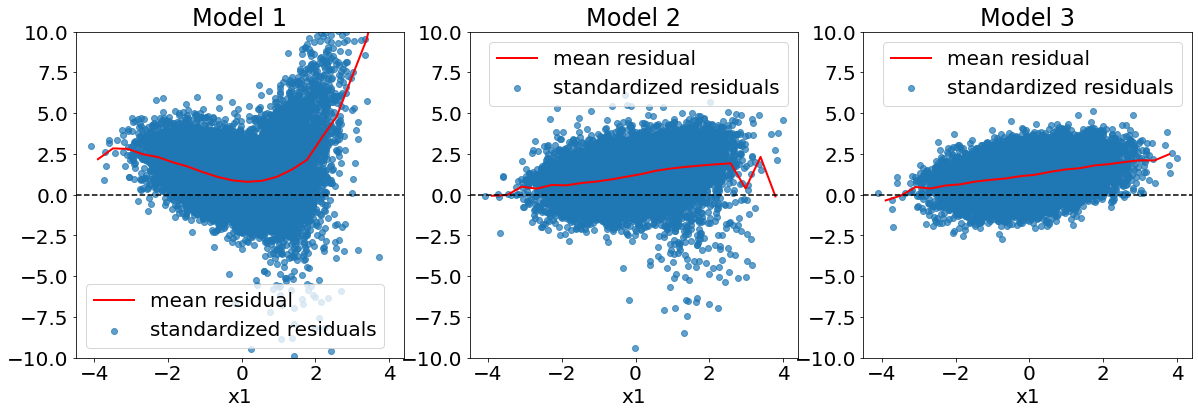

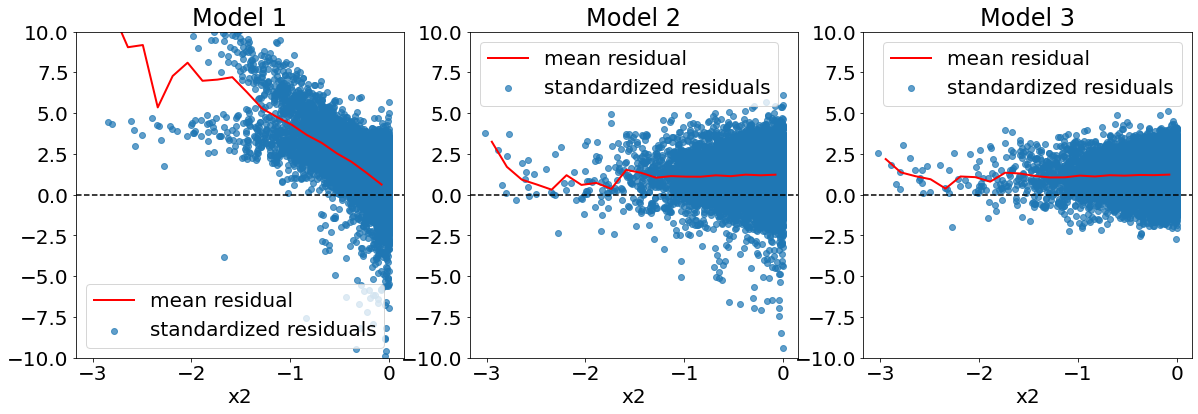

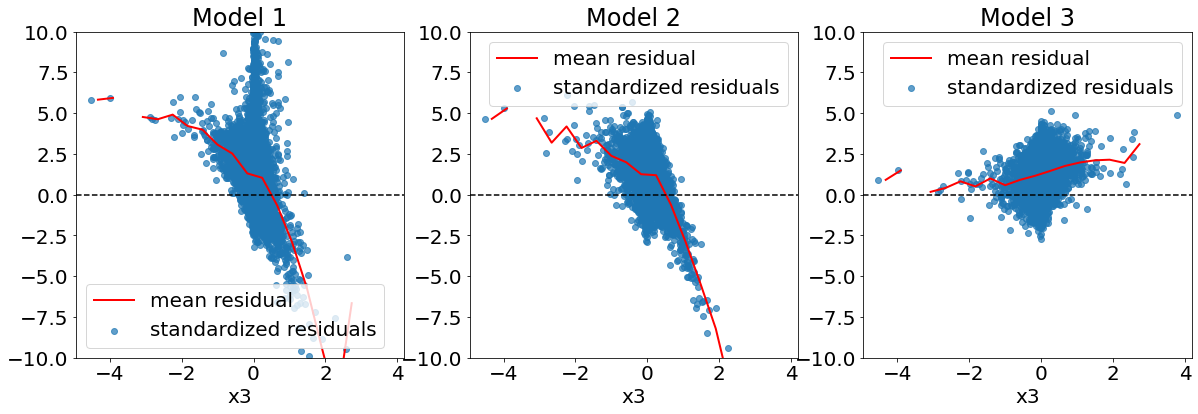

In [11]:
plot_residuals_wrapper(constrained=True, stratification_feature='x1')
plot_residuals_wrapper(constrained=True, stratification_feature='x2')
plot_residuals_wrapper(constrained=True, stratification_feature='x3')

## Estimating the direct effect of each feature on model bias 

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def compute_bias_effect_sizes(constrained, num_feat): 
    df = DATA[DATA['constrained'] == constrained].copy()

    feature_names = ['x1', 'x2', 'x3']
    features = df[feature_names]  
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(features)

    standardized_residuals = df[f'standardized_residuals_model{num_feat}']

    model = LinearRegression()
    model.fit(standardized_features, standardized_residuals)

    print(f"How much direct effect does each feature have on the bias of Model {num_feat}?")
    coefficients = model.coef_
    name_max, abs_coef_max = None, 0
    for name, coef in zip(feature_names, coefficients):
        print(f"Effect size of {name}: {coef}")
        if abs(coef) > abs_coef_max:
            name_max, abs_coef_max = name, abs(coef)

    print(
        f"Feature with the largest effect size: "
        f"{name_max} with absolute effect size {abs_coef_max}"
    )

compute_bias_effect_sizes(constrained=False, num_feat=1)

How much direct effect does each feature have on the bias of Model 1?
Effect size of x1: 0.10068645247414267
Effect size of x2: -1.1701511566900549
Effect size of x3: -0.8364123972525904
Feature with the largest effect size: x2 with absolute effect size 1.1701511566900549


In [13]:
compute_bias_effect_sizes(constrained=False, num_feat=2)

How much direct effect does each feature have on the bias of Model 2?
Effect size of x1: 0.34063469264109547
Effect size of x2: 0.0030311203371520268
Effect size of x3: -0.8145923672021409
Feature with the largest effect size: x3 with absolute effect size 0.8145923672021409


In [14]:
compute_bias_effect_sizes(constrained=False, num_feat=3)

How much direct effect does each feature have on the bias of Model 3?
Effect size of x1: -0.0006375660635135807
Effect size of x2: -0.0015818389660975354
Effect size of x3: 0.0028376927445056617
Feature with the largest effect size: x3 with absolute effect size 0.0028376927445056617


## Variations in model complexity, and bias in the residuals of the positive examples, dictate how performance varies with feature stratum

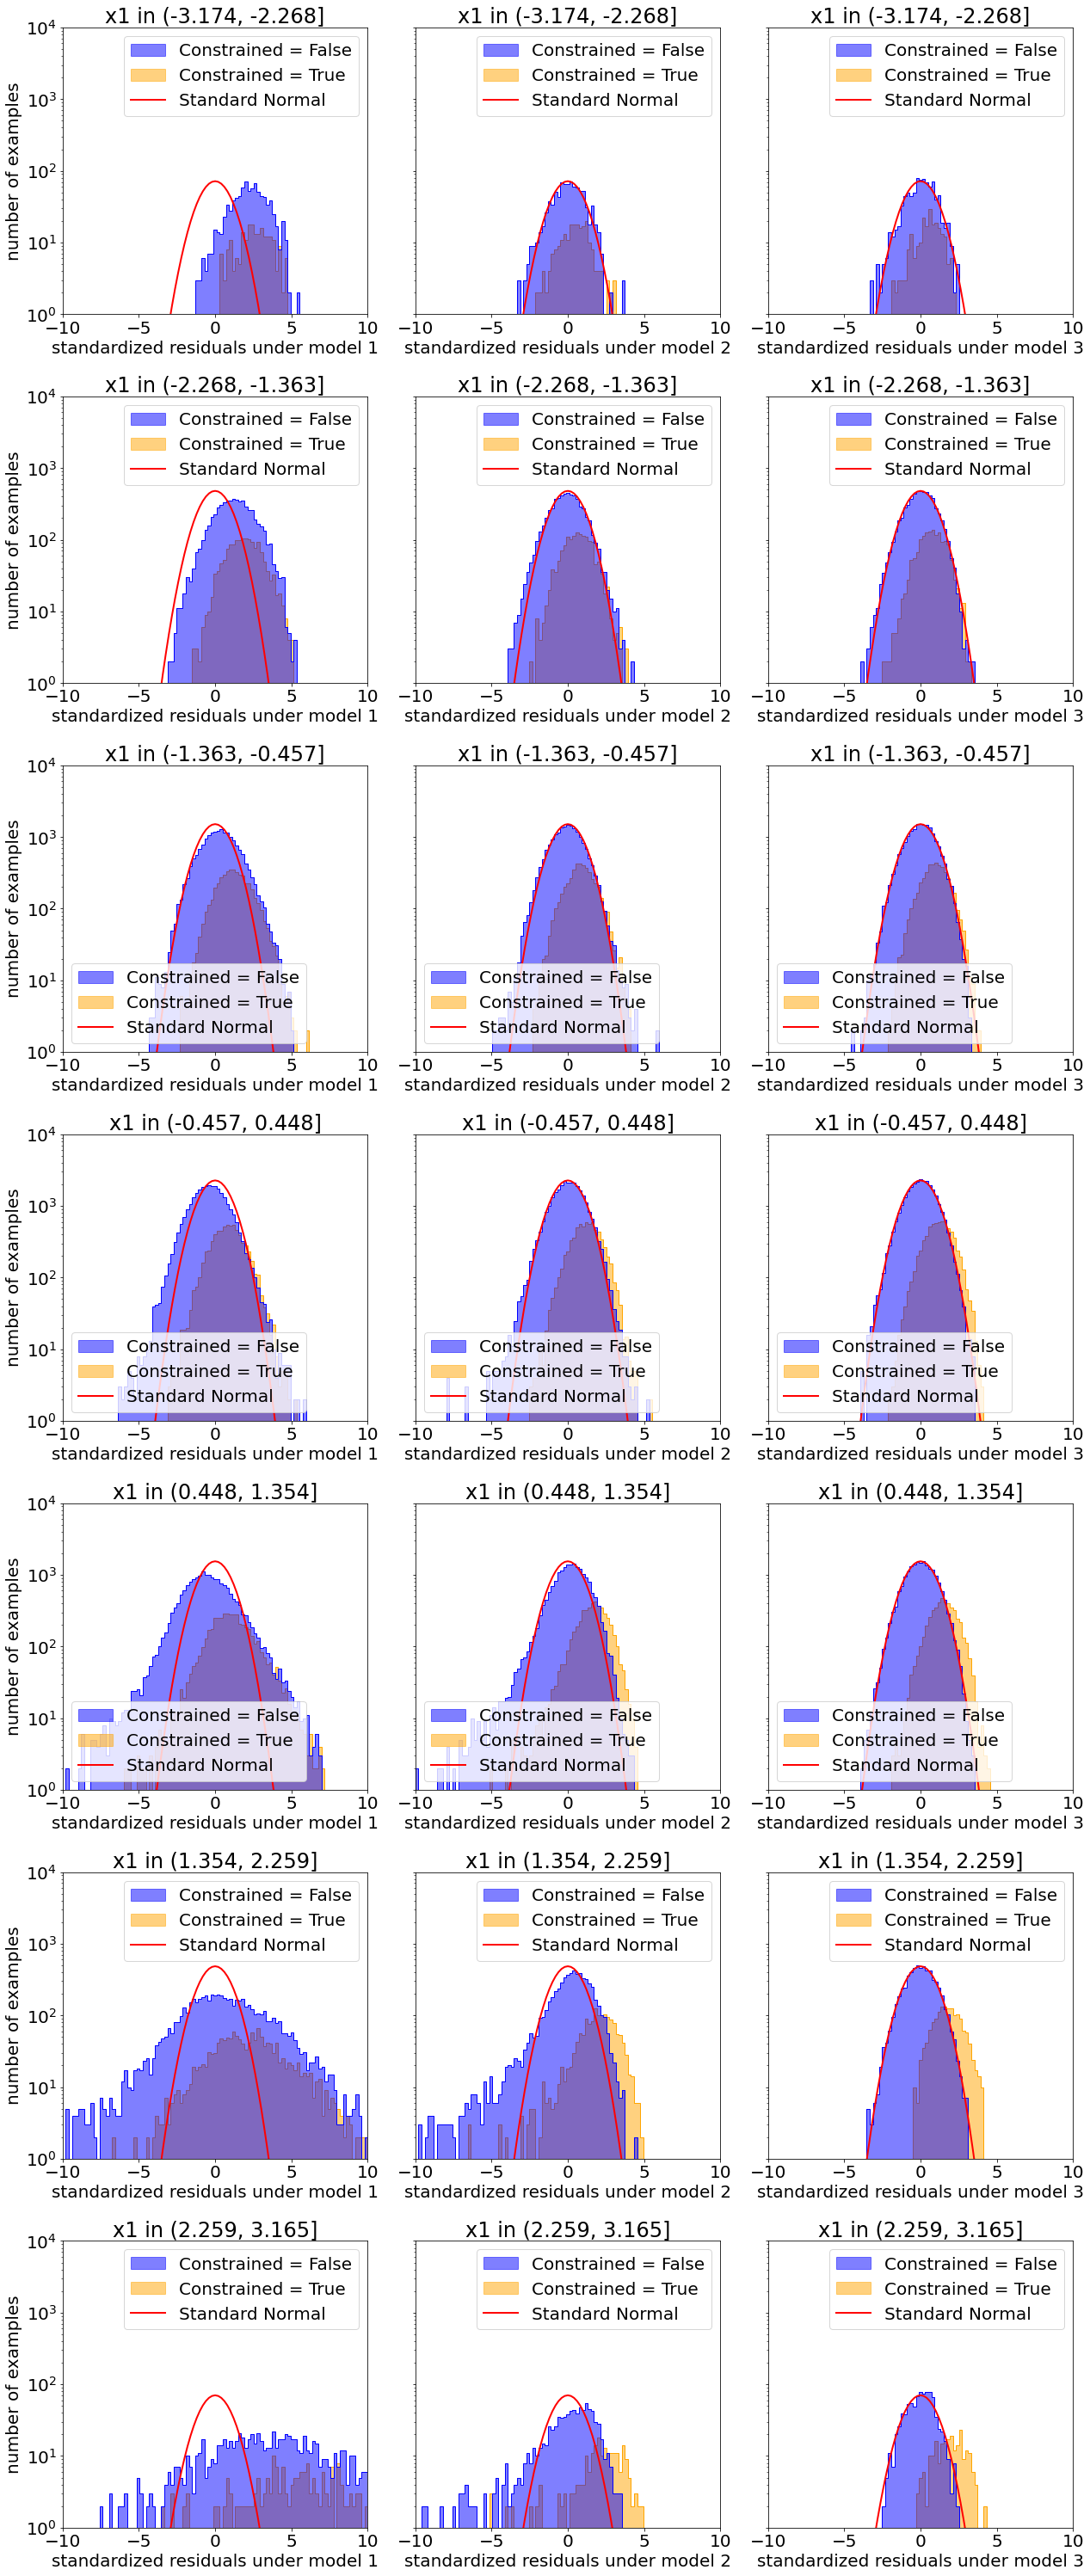

In [15]:
import seaborn as sns
from matplotlib.patches import Patch

NUMBER_EXAMPLES_MIN = 1000

def plot_residual_distributions():
    df = DATA.copy()

    df['x1_bin'] = (pd
        .cut(df['x1'], bins=10, labels=None)
    )
    groups = df.groupby('x1_bin')
    filtered_groups = {x1_bin: group for x1_bin, group in groups if len(group) > NUMBER_EXAMPLES_MIN}

    fig, axes = plt.subplots(len(filtered_groups), 3, figsize=(18, 6 * len(filtered_groups)), sharey=True)
    
    for i, (x1_bin, group) in enumerate(filtered_groups.items()):        
        for num_feat in range(1, 4):
            ax = axes[i, num_feat - 1] 

            bins = np.linspace(-10, 10, 100)
            bin_centers = (bins[1:] + bins[:-1]) / 2
            bin_width = bins[1] - bins[0]

            palette = {False: 'blue', True: 'orange'}
            alpha = 0.5  

            sns.histplot(
                data=group, 
                x=f'standardized_residuals_model{num_feat}', 
                hue='constrained', 
                kde=False, 
                element='step', 
                bins=bins, 
                ax=ax, 
                palette=palette, 
                alpha=alpha
            )

            # plot standard normal 
            x = bin_centers
            y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
            negative_class_count = len(group[group['constrained'] == False])
            y_scaled = y * negative_class_count * bin_width  
            normal_line, = ax.plot(x, y_scaled, color='red', lw=2)

            ax.set_xlabel(f'standardized residuals under model {num_feat}')
            ax.set_ylabel('number of examples')
            ax.set_title(f'x1 in {x1_bin}')
            ax.set_yscale('log')  
            ax.set_xlim(-10, 10)
            ax.set_ylim(1, 1e4)

            # Manually create legend handles and labels
            handles = [
                Patch(color=palette[False], alpha=alpha),
                Patch(color=palette[True], alpha=alpha),
                normal_line
            ]
            labels = [
                'Constrained = False', 
                'Constrained = True', 
                'Standard Normal'
            ]
            ax.legend(handles=handles, labels=labels)

    plt.tight_layout()
    plt.show()

plot_residual_distributions()

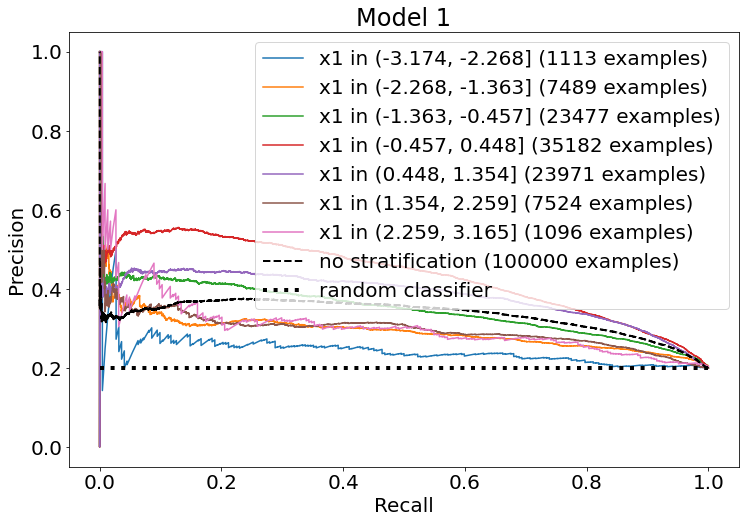

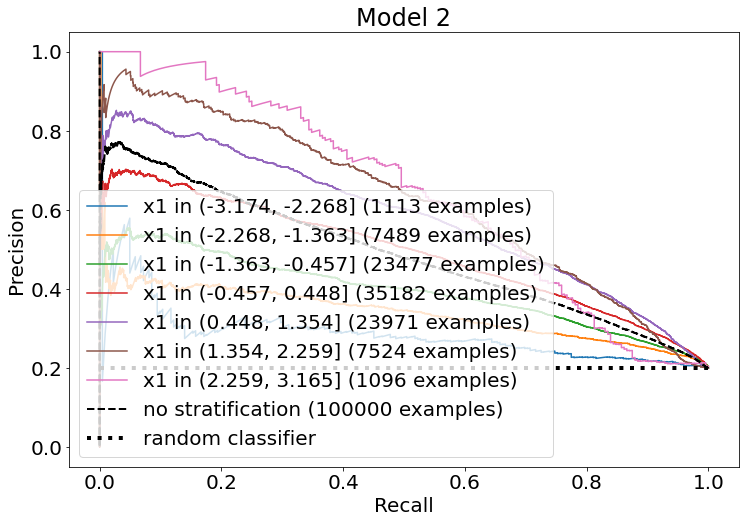

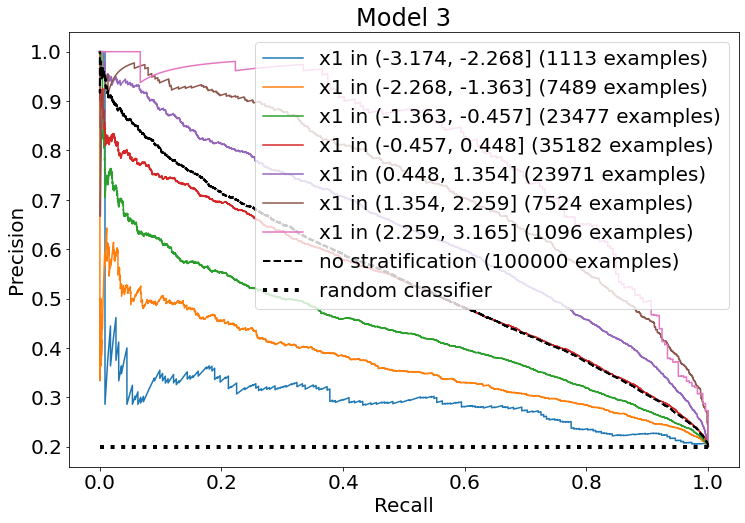

In [16]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curves(num_feat, stratification_feature):
    df = DATA.copy()

    df[f'{stratification_feature}_bin'] = (pd
        .cut(df[stratification_feature], bins=10, labels=None)
    )
    groups = df.groupby(f'{stratification_feature}_bin')

    pr_curves = {}
    for x_bin, group in groups:        
        precision, recall, _ = precision_recall_curve(group['constrained'], group[f'standardized_residuals_model{num_feat}'])
        pr_curves[x_bin] = (precision, recall, len(group))

    plt.figure(figsize=(12, 8))
    for x_bin, (precision, recall, num_examples) in pr_curves.items():
        if num_examples > NUMBER_EXAMPLES_MIN:
            plt.plot(recall, precision, label=f'{stratification_feature} in {x_bin} ({num_examples} examples)')

    # no stratification    
    precision, recall, _ = precision_recall_curve(df['constrained'], df[f'standardized_residuals_model{num_feat}'])
    plt.plot(recall, precision, label=f'no stratification ({len(df)} examples)', color='black', lw=2, linestyle='--')

    plt.plot([0, 1], [POSITIVE_FRACTION, POSITIVE_FRACTION], color='black', lw=4, linestyle=':', label='random classifier')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(f'Model {num_feat}')
    plt.show()

def plot_pr_curves_wrapper(stratification_feature):
    plot_pr_curves(num_feat=1, stratification_feature=stratification_feature)
    plot_pr_curves(num_feat=2, stratification_feature=stratification_feature)
    plot_pr_curves(num_feat=3, stratification_feature=stratification_feature)

plot_pr_curves_wrapper(stratification_feature='x1')

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


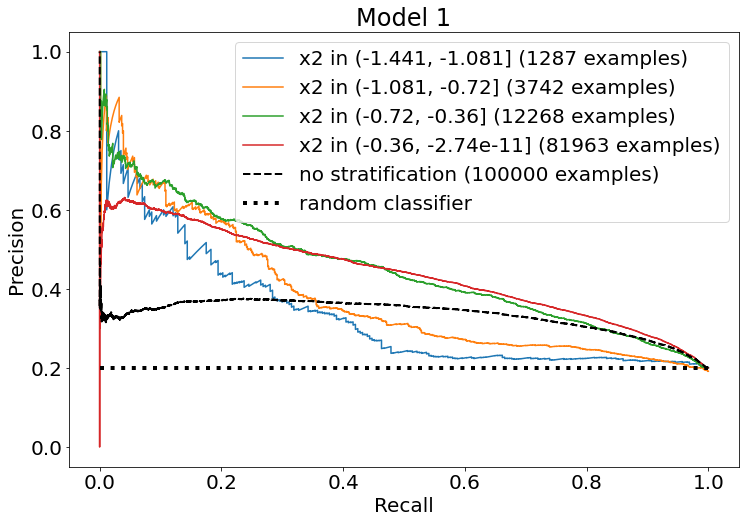

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


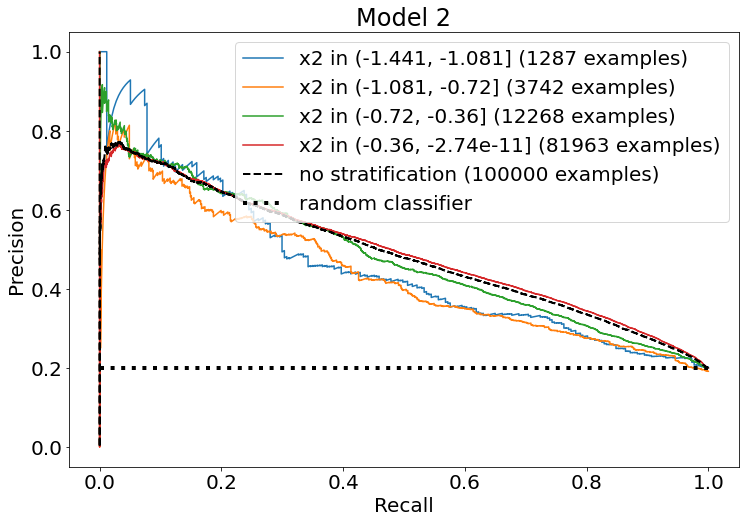

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


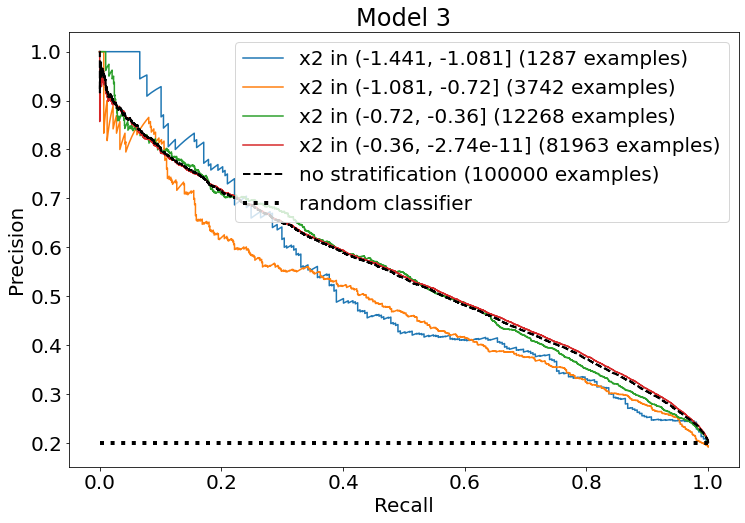

In [17]:
plot_pr_curves_wrapper(stratification_feature='x2')

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


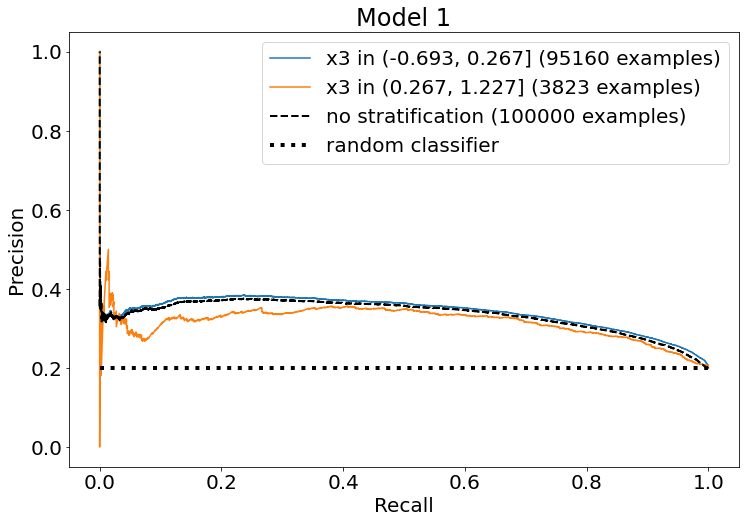

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


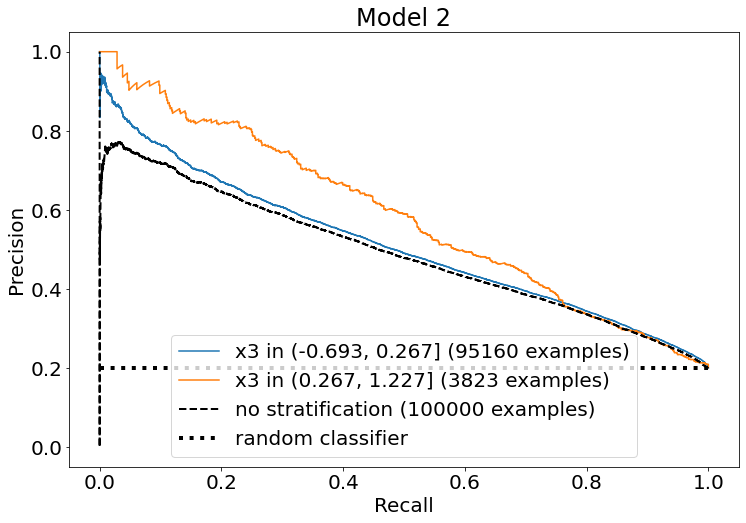

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


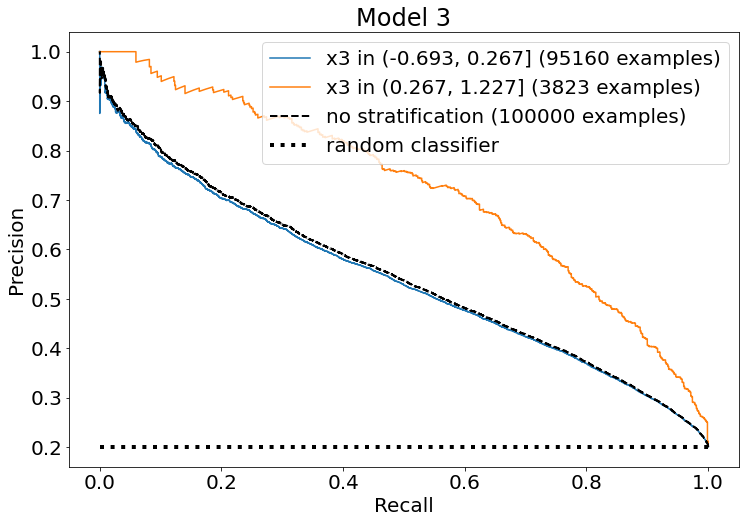

In [18]:
plot_pr_curves_wrapper(stratification_feature='x3')

## Other forms of model mis-specification 

In this notebook, I considered the case where a model fails to include features that actually affect the target. 

But, even if all relevant features are included, a model may still be mis-specified by failing to capture the true functional dependence of the target on the features. 
This scenario is explored at: https://nbviewer.org/github/petermchale/modeling_mutation_counts_using_neural_networks/blob/master/engineer_features/model/model.ipynb 